# QSVT for Quantum Credit Risk Analysis

## Libraries and data loading

In [1]:
# Import general purpose module(s)
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.primitives import StatevectorSampler, BackendSampler, BaseSampler
from qiskit_aer import Aer
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

# Import custom module(s)
from Code.multivariateGCI import MultivariateGCI_Linear
from Code.utils import bisection_search
from Code.circuitsCRA import get_expected_probability_circuit, get_expected_loss_circuitV2

### Input reading and parameter setting

In [2]:
# Set problem parameters
n_z = 2 # number of qubits used to represent each gaussian (risk factor)
z_max = 2 # gaussian's troncation values +/- 


p_zeros = [0.256, 0.072, 0.135, 0.072] # intrinsic probability of default for each asset
rhos = [0.090, 0.090, 0.090, 0.090]
lgd = [18406.56, 54807.94, 13719.59, 21127.25]

K = len(p_zeros)

F_values = [[0.158, 0.058], [0.256, 0.157], [0.158, 0.058], [0.158, 0.058]]  # values representing the correlation between assets and risk factors (first list asset, internal list correlation to risk factors)

n_shots = 2048
optimization_level = 1
alpha_var = 0.05

epsilon = 0.002
alpha_iae = 0.025

### Expected results

In [3]:
# Create the circuit to implement the custom-made Multivariate Gaussian Conditional Independence model
# based on multiple rotations (each asset undergoes one rotation for each risk factor)
uncertainty_model = MultivariateGCI_Linear(n_z, z_max, p_zeros, rhos, F_values)
display(uncertainty_model.draw())

job = StatevectorSampler().run([uncertainty_model.measure_all(inplace=False)], shots=n_shots)
binary_counts = job.result()[0].data.meas.get_counts()
binary_probabilities = {k: v / n_shots for k, v in binary_counts.items()}

p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []

for i, prob in binary_probabilities.items():
    # extract value of Z and corresponding probability
    i_normal = int(i[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    defaulted = []
    for k in range(K):
        if i[K - k - 1] == "1":
            defaulted.append(k)
            p_default[k] += prob
            loss += lgd[k]

    values += [loss]
    probabilities += [prob]

target_loss=sum(np.array(values)*np.array(probabilities))

values = np.array(values)
probabilities = np.array(probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha_var)
target_var = losses[i_var]

print(f"Expected result for VaR: {target_var}\nExpected Total Loss: {target_loss}")

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     │  P(X) │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     │       │
q_6: ┤6      ├
     │       │
q_7: ┤7      ├
     └───────┘

Expected result for VaR: 54807.94
Expected Total Loss: 11075.262939453123


## Circuit preparation to compute VAR (probability of a given loss)

Our approach is associating to each scenario a rotation of a target qubit that is proportional to the loss.
Then we use QSVT to select only states associated to loss greater than a given target loss.
What we are interested in is whether the computed probability is either greater or less than $1-\alpha$ to use bisection search.

We apply ideas presented in https://arxiv.org/pdf/2404.10088.
Soon after the run of the uncertainty model, the quantum state of the register is
$$
|\psi_0\rangle = \sum_{j=1}^{2^n-1}\sqrt{p_j}|w_j\rangle\otimes|j\rangle\otimes|0\rangle
$$
where $|w_j\rangle$ is a normalized statevector in the auxiliary register. Using binary notation, we associate each possible *scenario* of default to a number from $0$ to $2^n-1$.
We use $p_j$ to denote the probability of the $j$-th scenario and $L_j$ for the corresponding loss.

We scale down the possible losses to fit them in the interval $[0,1]$. We may be interested in applying some function, possibly increasing. So, let define 
$$
\tilde l_i = f\left(\frac{l_i}{\bar L}\right)
$$
$$
\tilde L_j = f\left(\frac{L_j}{\bar L}\right)
$$
for every $i \in\{1,\ldots,n\},\ j \in\{0,\ldots,2^{n}-1\}$ where $l_i$ denotes the loss given by default of the $i$-th asset and $\bar L$ the sum of all $l_i$'s.

 Finally, $f$ is a chosen additive function.

Now, consider the unitary operator $U$ such that
$$
 U|j\rangle|0\rangle = \cos(\tilde L_j) |j\rangle|0\rangle + \sin(\tilde L_j)|j\rangle|1\rangle
$$
namely
$$
    U = \sum_j |j\rangle\langle j|\otimes R_y^{2\tilde L_j}.
$$
Since $f$ is additive, the operator $U$ is realized by applying to the last qubit an $Y$-rotation of an angle $2\tilde l$ controlled by the $i$-th qubit of the counterparts register.
When we apply $U$ to $\psi_0$, we obtain
$$
|\psi\rangle = U|\psi_0\rangle = \sum_{j=0}^{2^n-1}\sqrt{p_j}|j\rangle \otimes \left( \prod_{i=1}^n\left(R_Y(\tilde l_i)\right)^{j_i}|0\rangle|w_j\rangle\right) 
= \sum_{j=0}^{2^n}\sqrt{p_j}|j\rangle \left(\sin(\tilde L_j)|1\rangle + \cos(\tilde L_j)|0\rangle\right).
$$
Our aim is computing probability that the loss is greater than some given value $T\in [0,\bar L]$.
We proceed by step, starting from QSVT.
Consider the projector
$$
    P_Y = I\otimes |0\rangle\langle 0| = \sum_j |j\rangle|0\rangle\langle j|\langle 0|
$$
and let $Y$ be the Hilbert subspace corresponding to its image.
Observe that
$$
    P_YUP_Y = \left(I\otimes |0\rangle\langle 0| \right) \left(\sum_j |j\rangle\langle j|\otimes R_y^{2\tilde L_j}\right) \left(I\otimes |0\rangle\langle 0|\right)
$$
$$
= \sum_j \left(I\otimes |0\rangle\langle 0| \right)\left(|j\rangle\langle j|\otimes \left(\cos(\tilde L_j)|0\rangle\langle 0| + \sin(\tilde L_j)|0\rangle\langle 1|\right) \right)
$$
$$
= \sum_j \left(|j\rangle\langle j|\otimes \left(\cos(\tilde L_j)|0\rangle\langle 0|\right) \right) = \sum_j \cos(\tilde L_j)\left(|j\rangle\langle j|\otimes \left(|0\rangle\langle 0|\right) \right) 
$$
By QSVT, given any real polynomial $p\in \mathbb R[x]$ such that $p(x)\leq 1$ when $x\in[-1,1]$, we may obtain an opearator $Q_U^p$ such that
$$
    \left(P_Y\otimes |0\rangle\langle 0|\right)Q_U^p\left(P_Y\otimes |0\rangle\langle0|\right) = \sum_j p(\cos(\tilde L_j))\left(|j\rangle\langle j|\otimes \left(|00\rangle\langle 00|\right) \right) 
$$
(note that $P_Y\otimes |0\rangle\langle 0| = I\otimes |0\rangle\langle 0| \otimes |0\rangle\langle 0| = I\otimes |00\rangle\langle 00|$).
Let $p$ be a polynomial approximation (for the sake of clarity we neglect the approximation error) of a function such that when evaluated in $\cos(\tilde L_j)$ equals $0$ whenever $L_j\leq T$ and equals $1$ otherwise. 
Then
$$
    \left(I\otimes I\otimes |00\rangle\langle 00|\right)(I\otimes Q_U^p)|\psi_0\rangle|0\rangle = \left(I\otimes I\otimes |00\rangle\langle 00|\right)(I\otimes Q_U^p) \sum_{j=1}^{2^n-1}\sqrt{p_j}|w_j\rangle\otimes|j\rangle\otimes|00\rangle
    =  \sum_{j=1}^{2^n-1}\sqrt{p_j}\left(I\otimes I\otimes |00\rangle\langle 00|\right)(I\otimes Q_U^p)(I\otimes I\otimes |00\rangle\langle 00|)\left(|w_j\rangle\otimes|j\rangle\otimes|00\rangle\right)
    = \sum_{j=1}^{2^n-1}\sqrt{p_j}|w_j\rangle\otimes\left(\left(I\otimes |00\rangle\langle 00|\right)Q_U^p\left(I\otimes |00\rangle\langle 00|\right)|j\rangle|00\rangle\right)
     = \sum_{j=1}^{2^n-1}\sqrt{p_j}|w_j\rangle\otimes\left(p(\cos(\tilde L_j))|j\rangle|00\rangle\right)
     = \sum_{j=1}^{2^n-1}\sqrt{p_j}p(\cos(\tilde L_j))|w_j\rangle|j\rangle|00\rangle
     = \sum_{j\mid L_j>T}\sqrt{p_j}|w_j\rangle|j\rangle|00\rangle
$$
that is, the probability of obtaining $00$ in the last two qubits equals the probability that the loss is greater than $T$. 

We use the following

**Theorem** (4, https://arxiv.org/pdf/2105.02859):
Let $A =\sum_{k}\sigma_k|w_k\rangle\langle v_k|$ be a
block encoding of a matrix, in a unitary matrix $U$, that is
$$
A = \tilde \Pi U \Pi
$$
for some projectors $\Pi = \sum_{k} |v_k\rangle\langle v_k|$, $\tilde \Pi = \sum_{k} |w_k\rangle\langle w_k|$.
Moreover, let $p$ be an even polynomial of (even) degree $d$, under certein hypothesis.
For every $\phi$, define
\begin{align}
P_{\phi} & = e^{i\phi(2\Pi - I)},\\
\tilde P_{\phi} & = e^{i\phi(2\tilde \Pi - I)}.
\end{align}
Then there exists a sequence of phases $\Phi = (\phi)_{i=1}^d$ such that, defined $U_\Phi$ as 
$$U_\Phi = \Pi_{i=1}^{d/2}\left(P_{\phi_{2i-1}} U^\dagger \tilde P_{\phi_{2i}} U\right)$$
we have
$\tilde \Pi U_\Phi \Pi = \sum_{k}p(\sigma_k)|w_k\rangle\langle v_k|$

In [4]:
poly_1000_ch=[]
poly_1000_ch_non_zero=[]
with open('coefficients_full.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    i=0
    for row in spamreader:
        if i%2 == 0:
            poly_1000_ch_non_zero.append(float(row[0]))
        i=i+1
        poly_1000_ch.append(float(row[0]))

    
poly_1000 = np.polynomial.chebyshev.cheb2poly(poly_1000_ch)


phases_qspPack=[]
with open('phases.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        phases_qspPack.append(float(row[0]))

/Users/ema/miniconda3/envs/qsp_cra/lib/python3.12/site-packages/numpy/polynomial/chebyshev.py:454: RuntimeWarning: overflow encountered in multiply
  c1 = polyadd(tmp, polymulx(c1)*2)
/Users/ema/miniconda3/envs/qsp_cra/lib/python3.12/site-packages/numpy/polynomial/polyutils.py:563: RuntimeWarning: overflow encountered in add
  c2[:c1.size] += c1


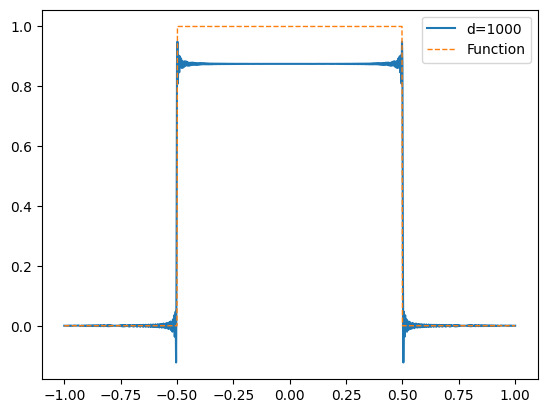

In [5]:
def plot_poly(poly, lin=1000, range_min=0, range_max=1., parity=0):
    xs = np.linspace(range_min, range_max, lin)

    ys = np.zeros(len(xs))
    y = np.arccos(xs)

    if parity == 0:
        for k in range(1, len(poly) + 1, 2):
            ys += poly[k - 1] * np.cos((k - 1) * y)
    else:
        for k in range(2, len(poly) + 1, 2):
            ys += poly[k - 1] * np.cos((k - 1) * y)

    # print(ys)
    figure = plt.figure()
    plt.plot(xs, ys)
    # add plot of a threshold function
    threshold_function = lambda x: 1 if np.abs(x) < 0.5 else 0
    ys_threshold = [threshold_function(x) for x in xs]
    plt.plot(xs, ys_threshold, linestyle="--", linewidth=1)
    plt.legend(["d=1000", "Function"])
    plt.savefig("poly_approx.pdf", format="pdf")

plot_poly(poly_1000_ch, lin=1001, range_min=-1, range_max=1, parity=0)

In [6]:
def cheby_coef_to_func(x, coef, parity, partialcoef=True):
    """
    Python equivalent of the MATLAB function ChebyCoef2Func.
    
    Parameters:
    x (array-like): Input array of x values.
    coef (array-like): Coefficients for the Chebyshev series.
    parity (int): Parity (0 or 1).
    partialcoef (bool): Determines the subset of coefficients to use.
    
    Returns:
    numpy.ndarray: Resultant array after applying the Chebyshev transformation.
    """
    ret = np.zeros(len(x))
    y = np.arccos(x)
    
    if partialcoef:
        if parity == 0:
            for k in range(1, len(coef) + 1):
                ret += coef[k - 1] * np.cos(2 * (k - 1) * y)
        else:
            for k in range(1, len(coef) + 1):
                ret += coef[k - 1] * np.cos((2 * k - 1) * y)
    else:
        if parity == 0:
            for k in range(1, len(coef) + 1, 2):
                ret += coef[k - 1] * np.cos((k - 1) * y)
        else:
            for k in range(2, len(coef) + 1, 2):
                ret += coef[k - 1] * np.cos((k - 1) * y)
    
    return ret

def compute_average(poly, lin=20, range_min=0, range_max=.5, chebichev=False):
    xs = np.linspace(range_min, range_max, lin)
    ys = np.array(cheby_coef_to_func(xs, poly, 0))
    return sum(ys)/len(ys)

poly_1000_ch_avg = compute_average(poly_1000_ch_non_zero, 1000, 0, 0.5, chebichev=True)

refactor = 1/poly_1000_ch_avg **2

In [7]:
def build_state_preparation_var(uncertainty_model, lgd, target_loss, phis:list=None, poly:list=None, do_print=False, epsilon=np.arcsin(0.5)) :
    state_preparation, objective, switch = get_expected_probability_circuit(len(lgd), uncertainty_model, lgd, target_loss, phases=phis, poly=poly, enable_switch=True, epsilon=epsilon)
    
    if do_print:
        display(state_preparation.decompose(reps=0).draw())
        decomposed_circ = state_preparation.decompose(reps=99)
        print('_____________________________________________________________________')
        print(f'Gates: {decomposed_circ.count_ops()}')
        print(f'Depth: {decomposed_circ.depth()}')
        print(f'Width: {decomposed_circ.width()}')
    
    return state_preparation, switch

## Number of shots for IQAE

By \[<https://arxiv.org/pdf/1912.05559>, Theorem 1\] the maximum number of shots requested for IQAE is

$$
N_{max}(\epsilon, \alpha) = \frac{32}{(1-2\sin(\pi/14))^2}\log\left( \frac{2}{\alpha}\log_2\left(\frac{\pi}{4\epsilon}\right) \right).
$$

We write a function to compute it.

In [8]:
def nMax(epsilon, alpha_iae):
    # print("espilon:",epsilon,"alpha_iae:", alpha_iae)
    ret = 32/(1-2*np.sin(np.pi/14))**2 * np.log((2/alpha_iae)*np.log2(np.pi/(4*epsilon)))
    # print(ret)
    return  ret

In [9]:
sampler_noiseless = BackendSampler(backend=Aer.get_backend('qasm_simulator'))

/var/folders/74/wt_5qpj93q3376cvntqjvnm80000gn/T/ipykernel_1087/3807994451.py:1: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler_noiseless = BackendSampler(backend=Aer.get_backend('qasm_simulator'))


In [10]:
from qiskit.circuit.library import CCXGate, XGate
from qiskit.circuit import QuantumRegister

In [11]:
def check_state_prep_cdf(state_preparation, switch, rescaling_factor=1):
    #  print("Check state preparation")
    target_measure = ClassicalRegister(2, 'target_measure')
    circuit = QuantumCircuit(*(state_preparation.qregs), target_measure)
    circuit.append(state_preparation, list(range(circuit.num_qubits)))
    circuit.measure(circuit.num_qubits-2, 0)
    circuit.measure(circuit.num_qubits-1, 1)
    # display(circuit.decompose(reps=2).draw("mpl"))
    results = StatevectorSampler().run([circuit], shots=100000).result()
    counts = results[0].data.target_measure.get_counts()
    # print(counts)
    # print(results.get_statevector())

    if switch:
        return counts.get('00',0)/sum(counts.values())*rescaling_factor
    else:
        return 1-counts.get('00',0)/sum(counts.values())*rescaling_factor

def estimateCdf(sampler: BaseSampler, limit_loss: float, phis, comparison=True, rf=1, debug=False) :
    '''
    Args:
        sampler : BaseSampler, the V1 sampler to use for the execution (iae does not support V2 currently).
        limit_loss : float, the minimum loss whose probability we are interested in 
        mcx: bool, whether to use polylogarithmic implementation of multi-control-not
    '''
    state_preparation, switch = build_state_preparation_var(uncertainty_model, lgd, limit_loss, phis)

    if comparison or debug:
        state_prep_result = check_state_prep_cdf(state_preparation, switch, rf)
        print(f'expected prob (cdf) for {limit_loss} with qsp WO iae: {state_prep_result:.5f}')

    if debug:
        return state_prep_result
    L_MAX = sum(lgd)
    
    shots = min([2048, int(nMax(epsilon, alpha_iae))])
    maximum_rounds_number=np.ceil(np.log2(np.pi/(8*epsilon)))
    # print(f'number of shots: {shots}')
    sampler.set_options(default_shots = shots)

    if switch:
        post_processing_function = lambda x: x*rf
    else:
        post_processing_function = lambda x: 1-x*rf
    
    iae_target = QuantumRegister(1, 'iae_target')
    state_preparation_for_IAE = QuantumCircuit(*(state_preparation.qregs), iae_target)
    
    state_preparation_for_IAE.append(state_preparation, range(state_preparation.num_qubits))
    state_preparation_for_IAE.append(XGate(), [state_preparation.num_qubits-2])
    state_preparation_for_IAE.append(XGate(), [state_preparation.num_qubits-1])
    
    state_preparation_for_IAE.append(CCXGate(), [state_preparation.num_qubits-2, state_preparation.num_qubits-1, state_preparation.num_qubits])

    # display(state_preparation_for_IAE.draw())
    problem = EstimationProblem(state_preparation=state_preparation_for_IAE.decompose(reps=99),
                            objective_qubits=[state_preparation_for_IAE.num_qubits-1],
                            post_processing=post_processing_function)
    
    amplitude_estimation_instance = IterativeAmplitudeEstimation(epsilon, alpha=alpha_iae, sampler=sampler)
    result = amplitude_estimation_instance.estimate(problem)

    return eval(str(result))

In [12]:
import itertools
# compute all possible combinations summing float in given list and return list with combinations
possible_losses= [0]+[sum(comb) for r in range(1, len(lgd) + 1) for comb in itertools.combinations(lgd, r)]

possible_outcomes = [estimateCdf(sampler_noiseless, level, phis=phases_qspPack, rf=refactor, debug=True) for level in sorted(possible_losses)]

pd.set_option('display.max_colwidth', None)

# round values and put into dict
outcome_dict = {round(k,4): round(v, 4) for k, v in zip(sorted(possible_losses),possible_outcomes)}

expected prob (cdf) for 0 with qsp WO iae: 0.58262
expected prob (cdf) for 13719.59 with qsp WO iae: 0.66163
expected prob (cdf) for 18406.56 with qsp WO iae: 0.84858
expected prob (cdf) for 21127.25 with qsp WO iae: 0.89058
expected prob (cdf) for 32126.15 with qsp WO iae: 0.91616
expected prob (cdf) for 34846.84 with qsp WO iae: 0.92196
expected prob (cdf) for 39533.81 with qsp WO iae: 0.93319
expected prob (cdf) for 53253.4 with qsp WO iae: 0.93661
expected prob (cdf) for 54807.94 with qsp WO iae: 0.97727
expected prob (cdf) for 68527.53 with qsp WO iae: 0.98221
expected prob (cdf) for 73214.5 with qsp WO iae: 0.99474
expected prob (cdf) for 75935.19 with qsp WO iae: 1.00055
expected prob (cdf) for 86934.09 with qsp WO iae: 1.00404
expected prob (cdf) for 89654.78 with qsp WO iae: 1.00101
expected prob (cdf) for 94341.75 with qsp WO iae: 1.00453
expected prob (cdf) for 108061.34 with qsp WO iae: 1.00345


{0: np.float64(0.5826),
 13719.59: np.float64(0.6616),
 18406.56: np.float64(0.8486),
 21127.25: np.float64(0.8906),
 32126.15: np.float64(0.9162),
 34846.84: np.float64(0.922),
 39533.81: np.float64(0.9332),
 53253.4: np.float64(0.9366),
 54807.94: np.float64(0.9773),
 68527.53: np.float64(0.9822),
 73214.5: np.float64(0.9947),
 75935.19: np.float64(1.0006),
 86934.09: np.float64(1.004),
 89654.78: np.float64(1.001),
 94341.75: np.float64(1.0045),
 108061.34: np.float64(1.0035)}

In [ ]:
print("espilon:", epsilon, "alpha_iae:", alpha_iae)
bisection_search(estimateCdf, 1-alpha_var, 0, sum(lgd), sampler=sampler_noiseless, 
                 phis=phases_qspPack, rescaling_factor=refactor)

espilon: 0.002 alpha_iae: 0.025
-----------------------------------------------------------------------
start bisection search for target value 0.950
-----------------------------------------------------------------------
low_level      low_val    level         value   high_level    high_value
-----------------------------------------------------------------------


## Appendix A - Circuit preparation to compute expected loss

Suppose we have $n$ assets, enumerated from $1$ to $n$. Let $l_i$ denote the loss given by default of the $i$-th asset.
Using binary notation, we associate each possible *scenario* of default to a number from $0$ to $2^n-1$.
We use $p_j$ to denote the probability of the $j$-th scenario and $L_j$ for the corresponding loss.
We use $j_i$ to denote the $i$-th bit in the binary representation of $j$.
Thus $L_j = \sum_{i}^n j_il_i$.

We are interested in computing the expected loss, that is
$$
\mathbb E[L] = \sum_{j=0}^{2^n-1}p_j L_j.
$$

First of all, we scale down the values $l_i$ so that they are *small* in some sense that will be clearer later. So, let $c<1$ be a positive constant and let ${\bar L}$ be the sum of all $l_i$'s.
For every $i\in\{1,\ldots n\}$. We define
$$
\tilde l_i = c\left(\frac{ l_i }{ {\bar L} }\right).
$$
Since all $l_i$'s are positive, for every subset of the $\tilde l_i$'s, the sum of its components lies between $0$ and $c$.

Now, assume the quantum register's state is
$$
|\psi_0\rangle = \sum_{j=1}^{2^n-1}\sqrt{p_j}|j\rangle\otimes|0\rangle.
$$

We apply a $(\pi/2- c)$-rotation around $Y$ to the target qubit and, for every asset, i.e. for every $i\in\{1,\ldots,n\}$, we apply to the target qubit a $2\tilde l_i$-rotation around $y$ controlled by the $i$-th qubit, obtaining
$$
|\psi\rangle = \sum_{j=0}^{2^n-1}\sqrt{p_j}|j\rangle \otimes \left( \prod_{i=1}^n\left(R_Y(2\tilde l_i)\right)^{j_i}R_Y(\pi/2-c)|0\rangle\right).
$$

Recall that
$$ R_Y(\alpha)R_Y(\beta) = R_Y(\alpha + \beta)$$
and
$$
    R_Y(2\alpha)|0\rangle = \cos(\alpha)|0\rangle + \sin(\alpha)|1\rangle,
$$
thus
$$
\prod_{i=1}^n\left(R_Y(2\tilde l_i)\right)^{j_i}R_Y(\pi/2-c)|0\rangle = R_Y\left(\frac{\pi}{2} - c + 2\sum_{i=1}^n j_i\tilde l_i\right)|0\rangle = \cos\left(\frac{\pi}{4} - \frac{c}{2} + \sum_{i=1}^n j_i\tilde l_i\right)|0\rangle + \sin\left(\frac{\pi}{4} - \frac{c}{2} + \sum_{i=1}^n j_i\tilde l_i\right)|1\rangle
$$

and therefore
$$
|\psi\rangle = \sum_{j=0}^{2^n-1}\sqrt{p_j}|j\rangle \otimes \left( \cos\left(\frac{\pi}{4} - \frac{c}{2} + \sum_{i=1}^n j_i\tilde l_i\right)|0\rangle + \sin\left(\frac{\pi}{4} - \frac{c}{2} + \sum_{i=1}^n j_i\tilde l_i\right)|1\rangle \right).
$$

So, the probability of obtaining $1$ measuring the last qubit is given by
$$
    P_1 = \sum_{j=0}^{2^n-1}p_j \sin^2\left(\frac{\pi}{4} - \frac{c}{2} + \sum_{i=1}^n j_i\tilde l_i\right)
$$

where 
$$\sum_{i=1}^n j_i\tilde l_i = \sum_{i=1}^n j_i c \frac{l_i}{{\bar L}} = \frac{c}{{\bar L}}L_j$$
lies between $0$ and $c$ and thus $\frac{\pi}{4} - \frac{c}{2} + \sum_{i=1}^n j_i\tilde l_i$ lies between $\pi/4-c/2$ and $\pi/4 + c/2$.
Now, Taylor's expansion of $\sin^2(x)$ centered in $\pi/4$ is:

$$
    \sin^2(x) = \frac{1}{2} + (x - \pi/4) - \frac{4}{3!}(x-\pi/4)^3 + O(x-\pi/4)^5 = \frac{1}{2} + (x - \pi/4) - \frac{2}{3}(x-\pi/4)^3 + O(x-\pi/4)^5 = \frac{1}{2} + (x - \pi/4) + O(x-\pi/4)^3
$$


### Aside: Taylor's expansion
$$
\cos(2x) = 1 - 2\sin^2(x) \rightarrow \sin^2(x) = \frac{1 - \cos(2x)}{2}
$$
whence
\begin{align*}
    D^0[\sin^2(x)] & = \frac{1}{2}\left(1 - \cos(2x)\right)          & \rightarrow & D^0[\sin^2(x)]|_{\pi/4} = \frac{1}{2} \\
    D^1[\sin^2(x)] & = \frac{1}{2}(2\sin(2x))=\sin(2x) & \rightarrow & D^1[\sin^2(x)]|_{\pi/4} = 1\\
    D^2[\sin^2(x)] & = 2\cos(2x)                       & \rightarrow & D^2[\sin^2(x)]|_{\pi/4} = 0 \\
    D^3[\sin^2(x)] & = -4\sin(2x)                      & \rightarrow & D^3[\sin^2(x)]|_{\pi/4} = -4 \\
    D^4[\sin^2(x)] & = -8\cos(2x)                      & \rightarrow & D^4[\sin^2(x)]|_{\pi/4} = 0 \\
    D^5[\sin^2(x)] & = 16\sin(2x)                      & \rightarrow & D^2[\sin^2(x)]|_{\pi/4} = 16
\end{align*}

### Reprise

so that
\begin{multline*}
\sin^2\left(\frac{\pi}{4} - \frac{c}{2} + \sum_{i=1}^n j_i\tilde l_i\right) = \\
= \frac{1}{2} + \sum_{i=1}^n j_i\tilde l_i - \frac{c}{2} - \frac{2}{3}\left( - \frac{c}{2} + \sum_{i=1}^n j_i\tilde l_i \right)^3 + O\left(- \frac{c}{2} + \sum_{i=1}^n j_i\tilde l_i\right)^5
=\frac{1}{2} + \frac{c}{{\bar L}}L_j - \frac{c}{2} -\frac{2}{3}\left(- \frac{c}{2} +\frac{c}{{\bar L}}L_j\right)^3 + O\left(- \frac{c}{2} +\frac{c}{{\bar L}}L_i\right)^5 \\
= \frac{1}{2} + \frac{c}{{\bar L}}L_j - \frac{c}{2} -\frac{2}{3}\left(- \frac{c}{2} +\frac{c}{{\bar L}}L_j\right)^3 + O\left(c^5\right)
\end{multline*}

Thus we can approximate $P_1$ as
\begin{multline*}
P_1 \approx \sum_{j=0}^{2^n-1} p_j\left( \frac{1}{2} + \frac{c}{{\bar L}}L_j - \frac{c}{2} -\frac{2}{3}\left(- \frac{c}{2} +\frac{c}{{\bar L}}L_j\right)^3 + O\left(c^5\right) \right) \\
% =  \sum_{j=0}^{2^n-1} p_j\left(\frac{1}{2} + \frac{c}{{\bar L}}L_j - \frac{c}{2}+  O(c^3)\right)
= \frac{1}{2} + \frac{c}{{\bar L}}\sum_{j=0}^{2^n-1}p_jL_j - \frac{c}{2} -\frac{2}{3}\sum_{j=0}^{2^n-1}p_j\left(- \frac{c}{2} +\frac{c}{{\bar L}}L_j\right)^3 + O\left(c^5\right) \\
= \frac{1}{2} + \frac{c}{{\bar L}}\mathbb{E}[L] - \frac{c}{2} -\frac{2}{3}\sum_{j=0}^{2^n-1}p_j\left(- \frac{c}{2} +\frac{c}{{\bar L}}L_j\right)^3 + O\left(c^5\right)
\end{multline*}

whence
$$
\mathbb{E}[L] \approx \frac{{\bar L}}{c}\left(P_1 - \frac{1}{2} + \frac{c}{2}\right).
$$

In order to have an $\epsilon$-tolerance for $\mathbb E[L]$, we need an $\epsilon$-tolerance for $\frac{{\bar L}}{c}P_1$, that is a ${c\bar \epsilon}$-tolerance for $P_1$, where
$${\bar \epsilon}=\frac{\epsilon}{{\bar L}}.$$
This is achieved by executing at most $\frac{50}{{\bar \epsilon}c}\log\left(\frac{2}{\alpha}\log_2\left(\frac{\pi}{4{\bar \epsilon}c}\right)\right)$ queries of the grover operator (see https://arxiv.org/pdf/1912.05559, Theorem 1) and imposing (ignoring higher order summands):
$$
\left\vert\frac{2}{3}\sum_{j=0}^{2^n-1}p_j\left(- \frac{c}{2} +\frac{c}{{\bar L}}L_j\right)^3\right\vert \leq \frac{\epsilon c}{{\bar L}}=c{\bar \epsilon}.
$$

So we need $c$ to be as large as possible (to reduce the number of operations needed to obtain a certain precision), but respecting this last inequality. Since $L_j\leq {\bar L}$ for every $j$, we can simplify such inequality and obtain an optimal $c$ by solving
$$
\frac{2}{3}\left(\frac{c}{2}\right)^3 \leq c{\bar \epsilon}
$$
that is
$$
c\leq \sqrt{12{\bar \epsilon}}.
$$

So, a good choice of $c$ is 
$$c^* = 2\sqrt{3{\bar \epsilon}}.$$

Indeed, since in order to have an affordable confidence interval, we need to ask for half the required error, thus
$$
c^* = \sqrt{6{\bar \epsilon}}
$$

In [ ]:
#c_star=np.sqrt(2 * epsilon)
def best_c(epsilon, lgd) :
    L_MAX=sum(lgd)
    c_star=np.sqrt(6 * epsilon /L_MAX)
    return c_star
best_c(epsilon, lgd)

np.float64(0.006323501491233328)

Thus the upper bound of for the number of queries is 
$$
\frac{50}{{\bar \epsilon}2\sqrt{3{\bar \epsilon}}}
\log\left(
    \frac{2}{\alpha}\log_2\left(
        \frac{\pi}{4{\bar \epsilon}2\sqrt{3{\bar \epsilon}}}
    \right)
\right) = 
$$

$$
\frac{25}{\sqrt{3}{\bar \epsilon}^{3/2}}
\log\left(
    \frac{2}{\alpha}\log_2\left(
        \frac{\pi}{8\sqrt{3}{\bar \epsilon}^{2/3}}
    \right)
\right)
$$
that implies an $O\left(\epsilon^{-3/2}\log\log_2\left(\epsilon^{-3/2}\right)\right)$ complexity that is still better than the classical solution (that grows as $O\left(\epsilon^{-2}\right)$.

So we found a solution that makes the state preparation operator to grow linearly w.r.t. the number of counterparts, still keeping the *overall* number of Grover queries under control.
This linerarization of the circuit makes sense because having a shorter state preparation we may accept that the involved cirtuit are generally shorter as well.
However, since we need a better precision (${c\bar \epsilon}=2\sqrt{3}{\bar \epsilon}^{3/2}$), more iterations and, above all, larger exponents at the final iterations are needed, possibly making this lineraization useless.

Let $k$ be the exponent of the grover operator $Q$ at the last iteration. This is at most (see https://arxiv.org/pdf/1912.05559 B8)
$$
    k\leq \frac{K-2}{4}\leq \frac{N_{max}L_{max}}{4\epsilon} - \frac{1}{2}
$$
where $L_{max}$ is bounded by a constant and (Theorem 1)
$$
N_{max}=N_{max}(\epsilon, \alpha) = \frac{32}{(1-2\sin(\pi/14))^2}\log\left( \frac{2}{\alpha}\log_2\left(\frac{\pi}{4\epsilon}\right) \right).
$$

The maximal depth of the circuits we may need to execute in the process is at most
$$
 d_{max} = q N_{max}L_{max}\epsilon^{-1}/4 - q/2
$$
where $q=q(n)$ is the depth of grover operator.

When we adopt the exact exponential circuit in state preparation, $d_{max}$ is exponential with respect to the number of counterparts and grows as $\log\log_2(\epsilon^{-1})\epsilon^{-1}$ with respect to precision.
Conversely, when we adopt the approximated linear state preparation, $d_{max}$ is linear/polylogaritmic (see other sections) w.r.t. the number of counterparts and grows as $\log\log_2(\epsilon^{-1})\epsilon^{-3/2}$ w.r.t. to relative precision.
Thus this implementation is especially useful when several counterparts are involved.

In [ ]:
state_preparation_dict = {}
def build_state_preparation_eloss(uncertainty_model, lgd, c=0, state_preparation_dict = state_preparation_dict, do_print=False) :

    state_preparation, objective = get_expected_loss_circuitV2(len(lgd), uncertainty_model, lgd, c)
    state_preparation_dict[c]=(state_preparation, objective)

    if do_print:
        decomposed_el_circ = state_preparation.decompose(reps=10)
        print('_____________________________________________________________________')
        print(f'Gates: {decomposed_el_circ.count_ops()}')
        print(f'Depth: {decomposed_el_circ.depth()}')
        print(f'Width: {decomposed_el_circ.width()}')
    # display(decomposed_el_circ.draw())
    return state_preparation, objective